In [710]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [712]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [714]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [716]:
import seaborn as sns
import matplotlib.pyplot as plt


In [718]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split



# Load the CSV dataset
data = pd.read_csv('/Users/ridhithakur/Downloads/punjabi_lexicon.csv')



In [720]:
data.shape

(19010, 3)

In [722]:
# Adding the 'Sentiment' column based on the scores
threshold = 0.19

def classify_sentiment(row):
    if row['Positive Score'] - row['Negative Score'] > threshold:
        return 'positive'
    elif row['Negative Score'] - row['Positive Score'] > threshold:
        return 'negative'
    else:
        return 'neutral'

data['Sentiment'] = data.apply(classify_sentiment, axis=1)

# Ensure the 'Sentiment' column is correctly added
print(data.head())


      Word  Positive Score  Negative Score Sentiment
0  ਅਪ੍ਰਤੱਖ           0.125           0.625  negative
1     ਤੰਗਲ           0.000           0.000   neutral
2    ਸਿਲਾਈ           0.000           0.000   neutral
3    ਸੁਹਣੇ           0.750           0.000  positive
4   ਵਿਨਾਸ਼ੀ           0.000           0.750  negative


In [724]:
data = data.dropna(subset=['Word', 'Sentiment'])
# Check unique values in the Sentiment column
print("Unique values in Sentiment column:")
print(data['Sentiment'].unique())

# Check for outliers or unexpected values in Positive Score and Negative Score
print("Summary statistics for Positive Score:")
print(data['Positive Score'].describe())

print("Summary statistics for Negative Score:")
print(data['Negative Score'].describe())

Unique values in Sentiment column:
['negative' 'neutral' 'positive']
Summary statistics for Positive Score:
count    19010.000000
mean         0.147378
std          0.180280
min          0.000000
25%          0.000000
50%          0.125000
75%          0.250000
max          1.000000
Name: Positive Score, dtype: float64
Summary statistics for Negative Score:
count    19010.000000
mean         0.168183
std          0.205879
min          0.000000
25%          0.000000
50%          0.125000
75%          0.291667
max          1.000000
Name: Negative Score, dtype: float64


/var/folders/_j/gpk07jgx4wnbm9gvr4sjkyw00000gn/T/ipykernel_12256/3354587804.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


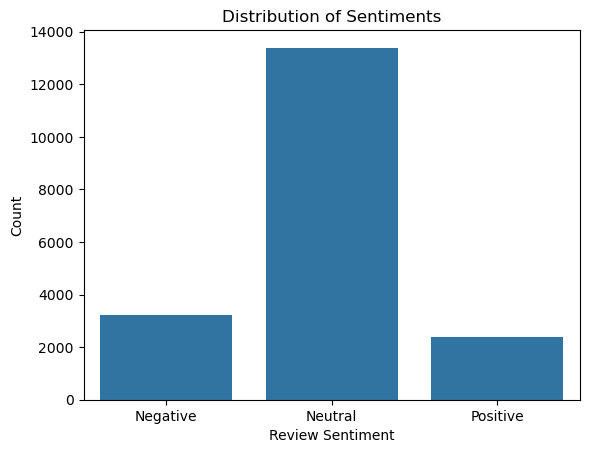

Sentiment
negative    3225
positive    2393
neutral     2393
Name: count, dtype: int64


In [726]:


# Plot the distribution of sentiments
class_names = ['Negative', 'Neutral', 'Positive']
ax = sns.countplot(x=data['Sentiment'])
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
ax.set_xticklabels(class_names)
plt.title('Distribution of Sentiments')
plt.show()
print(balanced_data['Sentiment'].value_counts())

In [728]:
# Separate majority and minority classes
neutral = data[data['Sentiment'] == 'neutral']
positive = data[data['Sentiment'] == 'positive']
negative = data[data['Sentiment'] == 'negative']

# Define the number of samples you want for the balanced dataset
num_samples = min(len(positive), len(negative))  # Choose the minimum count of the minority classes

# Randomly sample from the majority class (neutral)
neutral_undersampled = resample(neutral, 
                                replace=False,    # Do not sample with replacement
                                n_samples=num_samples,  # Match number of samples to minority classes
                                random_state=42)  # Set seed for reproducibility

# Combine the undersampled neutral class with the positive and negative classes
balanced_data = pd.concat([positive, negative, neutral_undersampled])

# Shuffle the data to mix the rows
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the class distribution in the balanced dataset
print("Class distribution in balanced dataset:")
print(balanced_data['Sentiment'].value_counts())


Class distribution in balanced dataset:
Sentiment
negative    3225
positive    2393
neutral     2393
Name: count, dtype: int64


/var/folders/_j/gpk07jgx4wnbm9gvr4sjkyw00000gn/T/ipykernel_12256/595734622.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


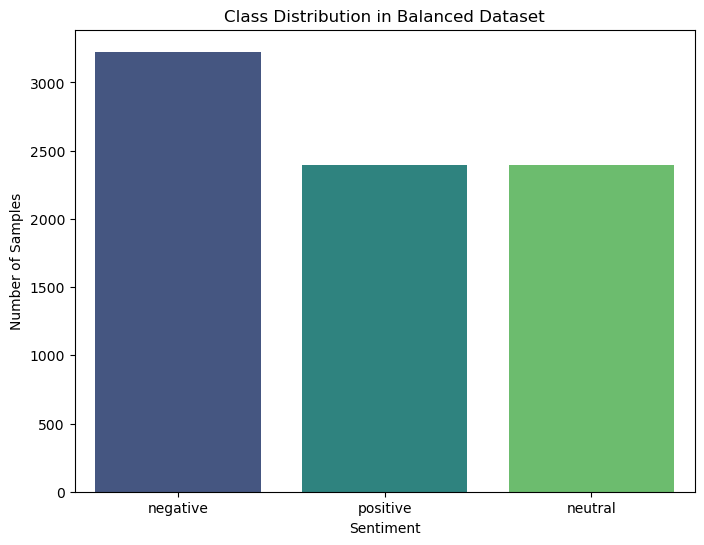

In [730]:
# Verify the class distribution in the balanced dataset
class_distribution = balanced_data['Sentiment'].value_counts()

# Create a bar plot for class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Balanced Dataset')
plt.show()

In [732]:
# Prepare input and target data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Word'])
X = tokenizer.texts_to_sequences(data['Word'])
X = pad_sequences(X)
y = pd.get_dummies(data['Sentiment']).values


In [734]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [736]:


# Define the enhanced RNN model
rnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=X.shape[1]),  # Increase embedding dimensions
    SimpleRNN(128, return_sequences=True),  # Increase the number of units and return sequences
    Dropout(0.5),  # Add dropout for regularization
    SimpleRNN(64),  # Another RNN layer for increased capacity
    Dense(64, activation='relu'),  # Add a dense layer
    Dense(y.shape[1], activation='softmax')  # Output layer
])

# Compile the RNN model

rnn_model.compile(
    optimizer=Adam(),
    loss=categorical_crossentropy,
    metrics=['accuracy', Precision(), Recall()]
)


# Train the RNN model
rnn_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


476/476 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7002 - loss: 0.8311 - precision_30: 0.6986 - recall_30: 0.6822 - val_accuracy: 0.7083 - val_loss: 0.8024 - val_precision_30: 0.7083 - val_recall_30: 0.7083
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7582 - loss: 0.6384 - precision_30: 0.7754 - recall_30: 0.7344 - val_accuracy: 0.5587 - val_loss: 1.1427 - val_precision_30: 0.5814 - val_recall_30: 0.5110
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9850 - loss: 0.0479 - precision_30: 0.9854 - recall_30: 0.9843 - val_accuracy: 0.5150 - val_loss: 1.2615 - val_precision_30: 0.5252 - val_recall_30: 0.4687
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9949 - loss: 0.0141 - precision_30: 0.9960 - recall_30: 0.9949 - val_accuracy: 0.6591 - val_loss: 1.3331 - val_precision_30: 0.6614 - val_recall_30: 0.6489
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9975 - loss: 0.0067 - precision_30: 0.9980 - recall_30: 0

In [738]:
from tensorflow.keras.layers import Embedding, GRU, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

In [740]:
# Define the very simple GRU model
gru_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=X.shape[1]),  # Minimal embedding dimensions
    GRU(32),  # Single GRU layer with 32 units
    Dense(y.shape[1], activation='softmax')  # Output layer with softmax activation
])

# Compile the very simple GRU model
gru_model.compile(
    optimizer=Adam(),  # Default learning rate
    loss=categorical_crossentropy,
    metrics=['accuracy']
)

# Train the very simple GRU model
gru_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7067 - loss: 0.8363 - val_accuracy: 0.7083 - val_loss: 0.8062
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7288 - loss: 0.6732 - val_accuracy: 0.6213 - val_loss: 0.9849
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9830 - loss: 0.0917 - val_accuracy: 0.6846 - val_loss: 1.0058
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9874 - loss: 0.0312 - val_accuracy: 0.6894 - val_loss: 1.0453
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9903 - loss: 0.0225 - val_accuracy: 0.6978 - val_loss: 1.1748
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9943 - loss: 0.0150 - val_accuracy: 0.6904 - val_loss: 1.2091
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9953 - loss: 0.0118 - val_accuracy: 0.6541 - val_loss: 1.2234
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9966 - loss: 0.0090 - val_accuracy: 0.6804 - val_

In [742]:


# Define the  LSTM model
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=X.shape[1]),  # Reduced embedding dimensions
    LSTM(64),  # Fewer LSTM units
    Dense(y.shape[1], activation='softmax')  # Output layer
])

# Compile the simpler LSTM model
lstm_model.compile(
    optimizer=Adam(),
    loss=categorical_crossentropy,
    metrics=['accuracy', Precision(), Recall()]
)

# Train the simpler LSTM model
lstm_model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))


Epoch 1/40


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


476/476 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7061 - loss: 0.8397 - precision_31: 0.6869 - recall_31: 0.6168 - val_accuracy: 0.7083 - val_loss: 0.8083 - val_precision_31: 0.7083 - val_recall_31: 0.7083
Epoch 2/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7160 - loss: 0.7283 - precision_31: 0.7283 - recall_31: 0.7040 - val_accuracy: 0.6291 - val_loss: 0.9865 - val_precision_31: 0.6915 - val_recall_31: 0.4900
Epoch 3/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9078 - loss: 0.2095 - precision_31: 0.9154 - recall_31: 0.8998 - val_accuracy: 0.5345 - val_loss: 1.0473 - val_precision_31: 0.6267 - val_recall_31: 0.3714
Epoch 4/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9864 - loss: 0.0633 - precision_31: 0.9884 - recall_31: 0.9841 - val_accuracy: 0.6894 - val_loss: 1.0567 - val_precision_31: 0.6949 - val_recall_31: 0.6733
Epoch 5/40
476/476 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9903 - loss: 0.0238 - precision_31: 0.9914 - recall_31: 0

In [744]:
# Evaluate RNN model
rnn_evaluation = rnn_model.evaluate(X_test, y_test)
rnn_loss = rnn_evaluation[0]
rnn_accuracy = rnn_evaluation[1]
print(f"RNN Test Loss: {rnn_loss:.4f}, Test Accuracy: {rnn_accuracy:.4f}")

# Evaluate GRU model
gru_evaluation =gru_model.evaluate(X_test, y_test)
gru_loss = gru_evaluation[0]
gru_accuracy =minimal_gru_evaluation[1]
print(f"GRU Test Loss: {gru_loss:.4f}, Test Accuracy: {gru_accuracy:.4f}")




# LSTM model
lstm_evaluation = lstm_model.evaluate(X_test, y_test)
lstm_loss = lstm_evaluation[0]
lstm_accuracy = lstm_evaluation[1]
print(f"Simple LSTM Test Loss: {lstm_loss:.4f}, Test Accuracy: {simple_lstm_accuracy:.4f}")



# Predict sentiment for new sentences
punjabi_sentences = [
    "ਮੇਰਾ ਨਾਮ ਰਿੱਧੀ ਹੈ। ਮੈ ਅੱਜ ਬਹੁਤ ਖੁਸ਼ ਹਾਂ।",
    "ਤੁਸੀਂ ਇਹ ਬੜਾ ਚੰਗਾ ਕੰਮ ਕਰ ਰਹੇ ਹੋ।",
    "ਮੈਨੂੰ ਬਿਲਕੁਲ ਪਸੰਦ ਨਹੀਂ ਹੈ।"
]

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.6958 - loss: 2.4037 - precision_30: 0.6960 - recall_30: 0.6956
RNN Test Loss: 2.4289, Test Accuracy: 0.6970
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.6791 - loss: 1.6323
GRU Test Loss: 1.6140, Test Accuracy: 0.6781
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.6870 - loss: 1.9751 - precision_31: 0.6872 - recall_31: 0.6861
Simple LSTM Test Loss: 1.9350, Test Accuracy: 0.6860


In [746]:
# Tokenize and pad new sentences
punjabi_sequences = tokenizer.texts_to_sequences(punjabi_sentences)
punjabi_sequences = pad_sequences(punjabi_sequences, maxlen=X.shape[1])

# Predict sentiment using the GRU model
sentiment_labels = ['negative', 'neutral', 'positive']
prediction = rnn_model.predict(punjabi_sequences)

# Display predictions
for i, prediction in enumerate(predictions):
    sentiment = sentiment_labels[np.argmax(prediction)]
    print(f"Sentence: {punjabi_sentences[i]} - Predicted Sentiment (RNN): {sentiment}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Sentence: ਮੇਰਾ ਨਾਮ ਰਿੱਧੀ ਹੈ। ਮੈ ਅੱਜ ਬਹੁਤ ਖੁਸ਼ ਹਾਂ। - Predicted Sentiment (RNN): neutral
Sentence: ਤੁਸੀਂ ਇਹ ਬੜਾ ਚੰਗਾ ਕੰਮ ਕਰ ਰਹੇ ਹੋ। - Predicted Sentiment (RNN): positive
Sentence: ਮੈਨੂੰ ਬਿਲਕੁਲ ਪਸੰਦ ਨਹੀਂ ਹੈ। - Predicted Sentiment (RNN): negative


In [748]:
predictions2 = gru_model.predict(punjabi_sequences)
for i, prediction in enumerate(predictions2):
    sentiment = sentiment_labels[np.argmax(prediction)]
    print(f"Sentence: {punjabi_sentences[i]} - Predicted Sentiment (GRU): {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Sentence: ਮੇਰਾ ਨਾਮ ਰਿੱਧੀ ਹੈ। ਮੈ ਅੱਜ ਬਹੁਤ ਖੁਸ਼ ਹਾਂ। - Predicted Sentiment (GRU): neutral
Sentence: ਤੁਸੀਂ ਇਹ ਬੜਾ ਚੰਗਾ ਕੰਮ ਕਰ ਰਹੇ ਹੋ। - Predicted Sentiment (GRU): positive
Sentence: ਮੈਨੂੰ ਬਿਲਕੁਲ ਪਸੰਦ ਨਹੀਂ ਹੈ। - Predicted Sentiment (GRU): negative


In [750]:
predictions4 =lstm_model.predict(punjabi_sequences)
for i, prediction in enumerate(predictions4):
    sentiment = sentiment_labels[np.argmax(prediction)]
    print(f"Sentence: {punjabi_sentences[i]} - Predicted Sentiment (LSTM): {sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Sentence: ਮੇਰਾ ਨਾਮ ਰਿੱਧੀ ਹੈ। ਮੈ ਅੱਜ ਬਹੁਤ ਖੁਸ਼ ਹਾਂ। - Predicted Sentiment (LSTM): neutral
Sentence: ਤੁਸੀਂ ਇਹ ਬੜਾ ਚੰਗਾ ਕੰਮ ਕਰ ਰਹੇ ਹੋ। - Predicted Sentiment (LSTM): positive
Sentence: ਮੈਨੂੰ ਬਿਲਕੁਲ ਪਸੰਦ ਨਹੀਂ ਹੈ। - Predicted Sentiment (LSTM): negative
